# Computer Vision Final Project - Spring '18

## Card Detection

Submitted By : 
    
    Ishita Verma (iv447)
    Prashant Nigam (pn745)
    Rakshit Sareen (rs5606)
    Snehaa Ganesan (sg4860)


In [1]:
import os
import cv2
import glob
import numpy as np
import sys
from scipy import signal
from skimage import data, img_as_float
import PIL
from PIL import Image
import math
from matplotlib import pyplot as plt
%matplotlib inline

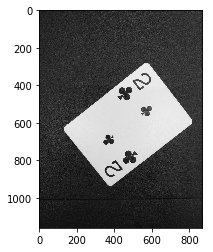

In [2]:
bwimage = "./testImage/testimage4.jpg"
bwimg = cv2.imread(bwimage,0)
plt.imshow(bwimg,cmap='gray')

In [3]:
def convolve2d(image, kernel, kernelsize):
    """
    This function assumes square kernels for now.
    """
    assert kernelsize%2 == 1 #this step is important
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image)
    image_padded = np.zeros((image.shape[0] + kernelsize - 1, image.shape[1] + kernelsize - 1))
    skipfactor = (kernelsize-1)/2
    skipfactor = int(skipfactor)
    image_padded[skipfactor:-skipfactor, skipfactor:-skipfactor] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x,y]=(kernel*image_padded[x:x+kernelsize,y:y+kernelsize]).sum()
    return output

In [4]:
def nonMaximumSeparation(accumulator):
    indices = []
    output = np.zeros_like(accumulator)
    for i in range(1,accumulator.shape[0]-1):
        for j in range(1,accumulator.shape[1]-1):
            # if i am maximum in neighborhood, keep me, else make me 0
            me, up , down , left , right = accumulator[i][j] ,accumulator[i-1][j] \
            , accumulator[i+1][j] , accumulator[i][j-1], accumulator[i][j+1]
            upleft, upright, bottomleft, bottomright = accumulator[i-1][j-1] \
            , accumulator[i-1][j+1],accumulator[i+1][j-1],accumulator[i+1][j+1]
            #print up,down,left,right
            if me >= up and me >= down and me>=left and me>=right and me >=upleft and me>=upright \
            and me>=bottomleft and me>=bottomright:
                continue
                #output[i][j] = me
            else:
                indices.append((i,j))
                #output[i][j] = 0
    for point in indices:
        accumulator[point[0]][point[1]] = 0
    return accumulator

In [5]:
# Calculation of Edge Map
def calculateEdgeMap(xderiv,yderiv):
    assert xderiv.shape == yderiv.shape
    output = np.zeros_like(xderiv)
    output = np.sqrt(np.square(xderiv) + np.square(yderiv))
    return output

In [6]:
# Orientation map : Calculating the arctan 
def calculateArctan(ix,iy, edgemap):
    assert ix.shape == iy.shape
    output = np.zeros_like(edgemap)
    output = np.arctan2(iy,ix)
    return output

In [7]:
def calculateHistogram(img):
    histogram = np.zeros(361)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            histogram[img[i,j]] += 1
    return histogram

In [8]:
def thresholding(histogram):
    output = np.zeros_like(histogram)
    for i in range(histogram.shape[0]):
        if histogram[i] >= 50000:
            output[i] = histogram[i]
    return output

In [9]:
def returnpeaks(histogram, thist):
    peaks = []
    th = thresholding(histogram)
    for i in range(th.shape[0]):
        if thist[i] != 0:
            peaks.append(i)
    return peaks

In [10]:
def thresholding_with_threshold(image, threshold):
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < threshold:
                output[i][j] = 0
            else:
                output[i][j] = 255  # image[i][j]
    return output

In [11]:
def houghTransform(image):
    diag = math.sqrt(math.pow(image.shape[0],2) + math.pow(image.shape[1],2))
    diag = int(diag)
    accumulator = np.zeros((diag,180))
    rho = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] != 0:
                for theta in range(0,180):
                    rho = int(i * math.cos(math.radians(theta)) + j* math.sin(math.radians(theta)))
                    accumulator[rho][theta] = accumulator[rho][theta] + 1
    return accumulator

In [12]:
def findPeaksIndices(accumulator):
    output = []
    for i in range(accumulator.shape[0]):
        for j in range(accumulator.shape[1]):
            if accumulator[i][j] != 0 :
                output.append((i,j))
    return output

In [13]:
def houghLines(peaklist,image):    
    coordinates = list()
    for point in peaklist:
        rho = point[0]
        theta = point[1]
        sintheta = math.sin(math.radians(theta))
        costheta = math.cos(math.radians(theta))
        if theta != 0:
            y1 = int(rho/sintheta)
            y2 = int((rho - image.shape[0]*costheta)/sintheta)            
            cv2.line(image,(y1,0),(y2,image.shape[0]),(255,0,0),4)
            coordinates.append((y1, 0, theta))
            coordinates.append((y2, image.shape[0], theta))
    return coordinates

# Running all the functions for image pre processing that involves rotating the input image and cropping

In [14]:
def preProcessingImage(bwimg):
    #Running all the functions
    kernel5X5 = np.ones((5,5),np.float32)/25
    output = convolve2d(bwimg,kernel5X5,5)
    kernel3X3 = np.ones((3,3),np.float32)/9
    output = convolve2d(bwimg,kernel3X3,3)
    kernel13X13 = np.ones((13,13),np.float32)/169
    output = convolve2d(bwimg,kernel13X13,13)
    yderiv = np.array([[-0.5,0,0.5],[-0.5,0,0.5],[-0.5,0,0.5]])
    xderiv = np.array([[-0.5,-0.5,-0.5],[0,0,0],[0.5,0.5,0.5]])
    kernel = np.ones((41,41),np.float32)/1681

    smoothimg = cv2.GaussianBlur(bwimg,(13,13),0)
    output = convolve2d(smoothimg,yderiv,3)
    iy = np.copy(output)
    output = convolve2d(smoothimg,xderiv,3)
    ix = np.copy(output)

    edgemap = calculateEdgeMap(ix,iy)
    edgemap = (edgemap / np.max(edgemap)) * 255
    edgemap = edgemap.astype(int)
    orientationmap = calculateArctan(ix,iy,edgemap)
    orientationmap = (orientationmap / np.max(orientationmap)) * 360
    orientationmap = orientationmap.astype(int)
    new_histogram = calculateHistogram(orientationmap)
    #y = plt.hist(range(0,new_histogram.shape[0]),weights = new_histogram, bins = 360)

    thist = thresholding(new_histogram)
    #y = plt.hist(range(0,thist.shape[0]),weights = thist, bins = 360)

    
    peaks = returnpeaks(new_histogram, thist)
    peaks = [x for x in peaks if x != 0]
    edgemap_t = thresholding_with_threshold(edgemap,100)
    _edgemap_t = thresholding_with_threshold(edgemap,50)
    newimage = (_edgemap_t - edgemap)
    acc = houghTransform(edgemap_t)
    acck = np.ones((5,5),np.float32)/25
    smoothed_acc = convolve2d(acc, acck, 5)
    edgyacc = nonMaximumSeparation(smoothed_acc)
    threshold_acc = thresholding_with_threshold(edgyacc,250)
    peaklist = findPeaksIndices(threshold_acc)

    thetas = [peaklist[i][1] for i in range(len(peaklist)) if peaklist[i][1] <= 90]
    test_hough_image = cv2.imread('./testImage/testimage4.jpg',0)
    coordinates = houghLines(peaklist,test_hough_image)

    
    plt.imshow(test_hough_image,cmap='gray')
    
    cv2.imwrite("houghlines.jpg", test_hough_image)



    avg_angle = 90 - np.mean(thetas)
    avg_angle
    # img = test_hough_image
    img = cv2.imread('./testImage/testimage4.jpg',0)
    rows,cols = img.shape
    centre = (cols/2,rows/2)
    M = cv2.getRotationMatrix2D(centre,avg_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    plt.imshow(dst,cmap='gray')
    cv2.imwrite("rotated_input.jpg", dst)


    sample_template = cv2.imread('./testImage/testimage4.jpg', 0)
    sample_template = Image.open('./sampleTemplate/sample_template.jpg')

    width,height = sample_template.size

    template_shape = cv2.imread('./sampleTemplate/sample_template.jpg', 0)

    shape = template_shape.shape

    plt.figure(figsize=(20,10))
    sample_template = cv2.imread('input1.jpg',0)
    shape = (500,500)
    scaled = cv2.resize(dst, shape) 
    r = cv2.selectROI(scaled, False, False)     
    cv2.destroyAllWindows()
       
    imCrop = scaled[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    preProcessedImage2 = cv2.resize(imCrop, (width,height))

    plt.imshow(preProcessedImage2,cmap='gray')
    cv2.imwrite("input1.jpg",preProcessedImage2)
    return bwimg,preProcessedImage2

In [15]:
def convolve2d(image, kernel, kernelsize):
    """
    This function assumes square kernels for now.
    """
    assert kernelsize%2 == 1 #this step is important
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image)
    image_padded = np.zeros((image.shape[0] + kernelsize - 1, image.shape[1] + kernelsize - 1))
    skipfactor = int((kernelsize-1)/2)
    image_padded[skipfactor:-skipfactor, skipfactor:-skipfactor] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            output[x,y]=(kernel*image_padded[x:x+kernelsize,y:y+kernelsize]).sum()
    return output

In [16]:
def templateMatcher(image, template,row,col):
    (tr,tc) = template.shape
    padimg = pad_image = np.pad(image, ((tr,tr),(tc,tc)), 'constant')
    output = np.zeros(image.shape)
    mean_template = calculateZeroMeanTemplate(template)

    for i in range(row):
        for j in range(col):

            region = padimg[i:i+tr,j:j+tc]
            region = calculateZeroMeanTemplate(region)

            assert (region.shape == template.shape), 'Dimensional mis-match'

            mregion = np.multiply(region, mean_template)
            total_magnitude = np.linalg.norm(region) * np.linalg.norm(mean_template)

            if (total_magnitude == 0):
                output[i][j] = -1
            else:
                output[i][j] = np.sum(mregion)/total_magnitude

    return output

In [17]:
def calculateZeroMeanTemplate(template):
    mean = np.mean(template)
    output = template - mean
    return output



In [18]:
def thresholder(matched_img, val):
    threshold_img = np.copy(matched_img)
    threshold_img[matched_img < val] = 0
    return threshold_img



In [19]:
def detectCards(temp_list,preProcessedImage,temp_type):
    for templates in temp_list:
        template = cv2.imread(templates,0)

        smoothimg = cv2.GaussianBlur(preProcessedImage,(13,13),0)
        #smoothtemp = cv2.GaussianBlur(template,(13,13),0)

        w, h = template.shape[::-1]

        #based on type which template Matching to call ...
        if temp_type == 'suitMatch' or temp_type == 'fullMatch' :
            
            (row,col) = preProcessedImage.shape
            
            output = templateMatcher(smoothimg, template,row,col)
        elif temp_type == 'numberMatch':
            (row,col) = preProcessedImage.shape
            (row ,col)= (math.floor(row/2),math.floor(col/2))
            output = templateMatcher(smoothimg, template, row,col)

        #Setting threshold for different type of template Matcing
        if temp_type == 'suitMatch':
          
            threshold = 0.9
        elif temp_type == 'fullMatch':
            threshold = 0.5
        elif temp_type == 'numberMatch':
            threshold = 0.7



        #Thresholding and card detection
        ans = thresholder(output,threshold)
        loc = np.where( output >= threshold)



        detected = (loc[0].size)
        if detected != 0:
            type = templates.split("/")
            card_type = type[-1].split(".")
            if temp_type == 'suitMatch' or temp_type == 'fullMatch':
              
                print ("Card Type : ", card_type[0])
            elif temp_type == 'numberMatch':
                print ("Card Number : ", card_type[0])
            for pt in zip(*loc[::-1]):
                cv2.rectangle(preProcessedImage, (pt[0] - w,pt[1]-h), pt, (0,255,255), 2)
            break

    return preProcessedImage



In [20]:
def detectCards_fullmatch(temp_list,preProcessedImage,temp_type):
    for templates in temp_list:
        template = cv2.imread(templates,0)

        smoothimg = cv2.GaussianBlur(preProcessedImage,(13,13),0)
        #smoothtemp = cv2.GaussianBlur(template,(13,13),0)

        w, h = template.shape[::-1]

        #based on type which template Matching to call ...
        if temp_type == 'fullMatch' :
            
            (row,col) = preProcessedImage.shape
            
            output = templateMatcher(smoothimg, template,row,col)
        
        #Setting threshold for different type of template Matcing
        if temp_type == 'suitMatch':
          
            threshold = 0.9
        elif temp_type == 'fullMatch':
            threshold = 0.5
        elif temp_type == 'numberMatch':
            threshold = 0.7



        #Thresholding and card detection
        ans = thresholder(output,threshold)
        loc = np.where( output >= threshold)



        detected = (loc[0].size)
        if detected != 0:
            type = templates.split("/")
            card_type = type[-1].split(".")
            if temp_type == 'fullMatch':
              
                print ("Card Type : ", card_type[0])
            
            for pt in zip(*loc[::-1]):
                cv2.rectangle(preProcessedImage, (pt[0] - w,pt[1]-h), pt, (0,255,255), 2)
            break

    return preProcessedImage




# Running all the functions for template matching

Card Type :  club
Card Number :  2


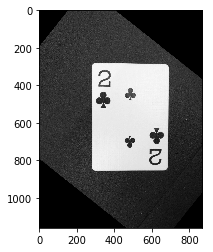

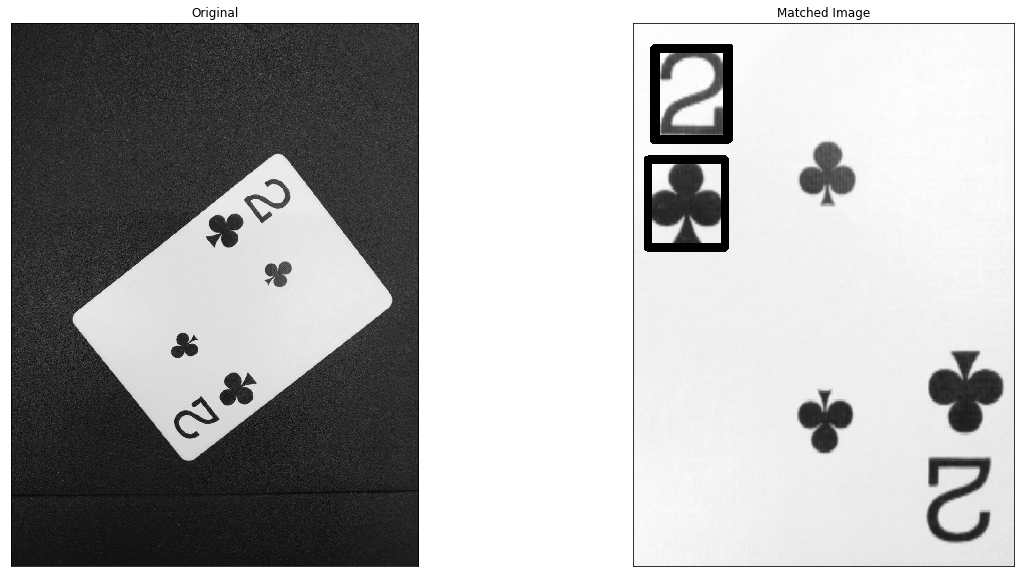

In [21]:



#Running all the functions for template matching

testImage = './testImage/testimage4.jpg'
imageToMatch = cv2.imread(testImage,0)
original_Image = np.copy(imageToMatch)

bwimg, preProcessedImage = preProcessingImage(bwimg)

plt.imshow(preProcessedImage,cmap='gray')
#preProcessedImage = cv2.resize(preProcessedImage)
#plt.imshow(preProcessedImage)
fullcard_Templates = glob.glob('./fullCardTemplate/*.jpg')
cardSuit_Templates = glob.glob('./cardSuite/*.jpg')
cardNumber_Templates = glob.glob('./cardNumber/*.jpg')
sample_template = glob.glob('./sampleTemplate/sample_template.jpg')


#When the card is kept at normalized position

#for full card Template detection
#matched_image = detectCards(fullcard_Templates,cropped_Image,'fullMatch')

#for face card suite detection
#matched_image = detectCards(faceCardSuite_Templates,cropped_Image,'suiteMatch')

#for normal card type detection
matched_image = detectCards(cardSuit_Templates,preProcessedImage,'suitMatch')

#for card number detection
matched_image = detectCards(cardNumber_Templates,preProcessedImage,'numberMatch')



plt.subplot(121),plt.imshow(bwimg,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(matched_image,cmap = 'gray')
plt.title('Matched Image'), plt.xticks([]), plt.yticks([])


'''Run the below commented line for full card template match - takes 30 minutes please be patient'''
#matched_image_fulltemplate = detectCards_fullmatch(fullcard_Templates,preProcessedImage,'fullMatch')
#plt.imshow(matched_image_fulltemplate,cmap='gray')

#cv2.imwrite("matched_fulltemplate.jpg", matched_image_fulltemplate)



cv2.imwrite("matched.jpg", matched_image)

plt.show()